<a href="https://colab.research.google.com/github/narrasriram/EMOTION-RECOGNITION-USING-FINE-TUNED-MODELS-ERFM-/blob/main/Colab%20Model%20building%20Files/Regression/Models%20on%20ISEAR%20Dataset/Random%20Forest%20Regression/ISEAR_Random_Forest_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  
# -*- coding: utf-8 -*-

# Author: Sriram Narra
# Course: CS 842
# Date: Apr 15, 2021
# Project Name: Emotion Recognition using Fine-tuned Models(ERFM)
# Description: This notebook builds a Random Forest Regression Model on ISEAR 
#              Dataset and checks the performance of the 
#              model with various model evaluation metrics
# --------------------------------------------------------------------------------

Importing the libraries

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from pandas import DataFrame
import textblob
from textblob import TextBlob
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the CSV data into Dataframe

In [ ]:
data_frame=pd.read_csv('/content/drive/MyDrive/Data Science Project/Datasets/ISEAR/Isear.csv')

In [ ]:
data_frame.head()

,Emotion,Text
0,anger,When a boy tried to fool me so he would be OK ...
1,anger,I felt anger when I saw that I was being misle...
2,anger,Once a friend had pushed me and I had fallen o...
3,anger,When I was misleaded by a person who assured t...
4,anger,I don't use to lie to my parets about what I d...


Subjectivity Score Retrieval Function Declaration

In [ ]:
def getScore(data):
  return TextBlob(data).sentiment.subjectivity

In [ ]:
data_frame["Subj_Score"] = data_frame["Text"].apply(getScore)

In [ ]:
data_frame.tail()

,Emotion,Text,Subj_Score
7661,shame,I felt this when I was copying homework for on...,0.000000
7662,shame,I experienced long ago when I was sightseeing ...,0.475000
7663,shame,Failing an examn because I did not work hard e...,0.520833
7664,shame,I was talking to a friend of mine about our pa...,0.000000
7665,shame,Arguing with a friend over politics. She was m...,0.300000


In [ ]:
print(data_frame["Emotion"].value_counts())

sadness    1096
anger      1096
shame      1096
disgust    1096
fear       1095
joy        1094
guilt      1093
Name: Emotion, dtype: int64


Remove those Records containing "[ No response.]" from dataframe

In [ ]:
data_frame.drop(data_frame[data_frame.Text=='[ No response.]'].index, inplace = True)
print("Total number of records containing the value [ No response.] after deletion is: "
                              +str(len(data_frame[data_frame.Text=='[ No response.]'])))

Total number of records containing the value [ No response.] after deletion is: 0


Outlier Analysis

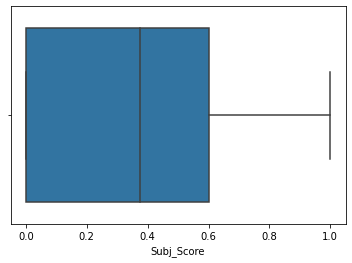

In [ ]:
import seaborn as sns
sns.boxplot(x=data_frame['Subj_Score'])

Balanced/Imbalanced Data check on Subjectivity Score Bins

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9de28df710>]],
      dtype=object)

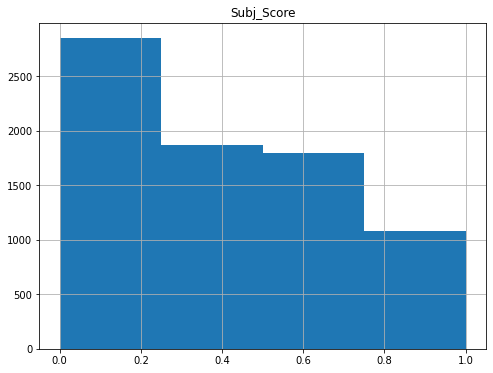

In [ ]:
data_frame.hist(column=['Subj_Score'],bins=4, figsize=(8,6))

Balancing the Imbalanced Data on majority of Subjectivity Score Bins

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9de2aaec10>]],
      dtype=object)

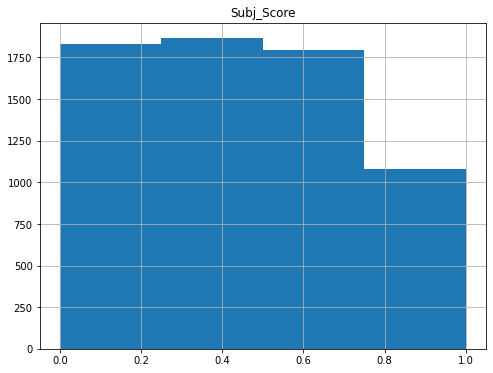

In [ ]:
count = 1
columns = ['Emotion', 'Text', 'Subj_Score']
zero_list = []
for ind, row in data_frame.iterrows():
  if(row['Subj_Score']==0.0 and count<=1000):
    zero_list.append(row.to_dict())
    count+=1
zero_df = pd.DataFrame(zero_list)
cond = data_frame['Text'].isin(zero_df['Text'])
data_frame.drop(data_frame[cond].index, inplace = True)
data_frame.hist(column=['Subj_Score'],bins=4, figsize=(8,6))

Missing Values Analysis

In [ ]:
data_frame.isnull().values.any()

False

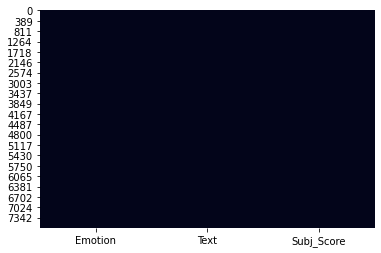

In [ ]:
sns.heatmap(data_frame.isnull(), cbar=False)

In [ ]:
len(data_frame)

6572

In [ ]:
data_frame.head()

,Emotion,Text,Subj_Score
0,anger,When a boy tried to fool me so he would be OK ...,0.500000
1,anger,I felt anger when I saw that I was being misle...,0.258333
2,anger,Once a friend had pushed me and I had fallen o...,0.400000
3,anger,When I was misleaded by a person who assured t...,0.500000
4,anger,I don't use to lie to my parets about what I d...,0.200000


Shuffling the dataset

In [ ]:
data_frame = data_frame.sample(frac=1).reset_index(drop=True)

Data Cleaning

In [ ]:
req_sentences_list = []
for i in range(0, len(data_frame)):
    substituted_sentence = re.sub('[^a-zA-Z]', ' ', data_frame['Text'][i])
    # Take the lower case alphabets of every sentence
    lower_cased_sentence = substituted_sentence.lower()

    # Split every word in the sentence
    splitted_sentence = lower_cased_sentence.split()

    # Stem every word to its root word
    ps = PorterStemmer()
    stemmed_sentence = [ps.stem(each_word) for each_word in splitted_sentence if not each_word in set(stopwords.words('english'))]

    # Join the divided words
    cleaned_sentence = ' '.join(stemmed_sentence)

    # Append the cleaned sentence to the list
    req_sentences_list.append(cleaned_sentence)

Label Encoding the Emotion Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_frame['Emotion'] = le.fit_transform(data_frame['Emotion'])

Transforming the Sentences into Features(By taking the 1589 words)

In [ ]:
feature_count_calc = CountVectorizer(max_features = 1)
X = feature_count_calc.fit_transform(req_sentences_list).toarray()
y = data_frame.iloc[:, 2].values

Scaling all the features into single scale

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

Split the dataset into Training and Testing sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Fitting Ranfom Forest Regressor to the Training set

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

Appending the additional removed records from the initial dataset in the test set

In [ ]:
req_sentences_list = []
for i in range(0, len(zero_df)):
    substituted_sentence_2 = re.sub('[^a-zA-Z]', ' ', zero_df['Text'][i])
    # Take the lower case alphabets of every sentence
    lower_cased_sentence_2 = substituted_sentence_2.lower()

    # Split every word in the sentence
    splitted_sentence_2 = lower_cased_sentence_2.split()

    # Stem every word to its root word
    ps = PorterStemmer()
    stemmed_sentence_2 = [ps.stem(each_word) for each_word in splitted_sentence_2 if not each_word in set(stopwords.words('english'))]

    # Join the divided words
    cleaned_sentence_2 = ' '.join(stemmed_sentence_2)

    # Append the cleaned sentence to the list
    req_sentences_list.append(cleaned_sentence_2)

additional_x_test = feature_count_calc.transform(req_sentences_list).toarray()
additional_y_test = zero_df.iloc[:, 2].values

scaled_additional_x_test = sc_X.transform(additional_x_test)

In [ ]:
X_test = np.concatenate((X_test, additional_x_test))
y_test = np.concatenate((y_test, additional_y_test))

Prediction of Testset Results

In [ ]:
y_pred = regressor.predict(X_test)

Mean Squared Error

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)

print(mse)

0.12223458992910641


Mean Absolute Error

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, y_pred)

0.3086204360022094

RMSE

In [ ]:
import math

root_mean_squared_error = math.sqrt(mse)
print(root_mean_squared_error)

0.3496206371613472


References:

1.  Edward Loper and Steven Bird. “NLTK: The Natural Language Toolkit”. In:CoRRcs.CL/0205028(2002).url:http://dblp.uni- trier.de/db/journals/corr/corr0205.html#cs- CL-0205028

2. Guido Van Rossum and Fred L. Drake.Python 3 Reference Manual. Scotts Valley, CA: CreateS-pace, 2009.isbn: 1441412697.

3.  F. Pedregosa et al. “Scikit-learn: Machine Learning in Python”. In:Journal of Machine LearningResearch12 (2011), pp. 2825–2830.

4. Conversion of Input into Word Features - https://github.com/narrasriram/data_science/blob/master/machine_learning/natural%20language%20processing/sentiment%20classification/natural_language_processing.py